## TODO
1. log_Feature by occurence
2. log_feature by volume

-> try both

There are a total of 100 log_features
There are 60 event types

In [1]:
import numpy as np
import sklearn
import pandas as pd
import matplotlib.pyplot as plt
import ggplot
import seaborn as sns
import random
import xgboost
from scipy.stats import gaussian_kde
%matplotlib inline

# Table of Contents


## Exploring the Data


In order to just process numeric data, i dropped the strings from all the csv files containing the description ('event_type ', 'log_feature ', 'resource_type') manually with microsoft excel.


<table style="width:20%", align ="left">
<tr><td>**Before**</td></tr>
<tr><td>*id*</td><td style = "width:60%" >*event_type*</td></tr>
<tr><td>9999</td><td >event_type 15</td></tr>
<tr><td>**After**</td></tr>
<tr><td>9999</td><td >15</td></tr>
</table>










In [2]:
train = pd.read_csv("Telstra/train.csv")
events = pd.read_csv("Telstra/event_type.csv")
log_feature = pd.read_csv("Telstra/log_feature.csv")
resources = pd.read_csv("Telstra/resource_type.csv")
test = pd.read_csv("Telstra/test.csv")
severity = pd.read_csv("Telstra/severity_type.csv")


### Univariant Analysis

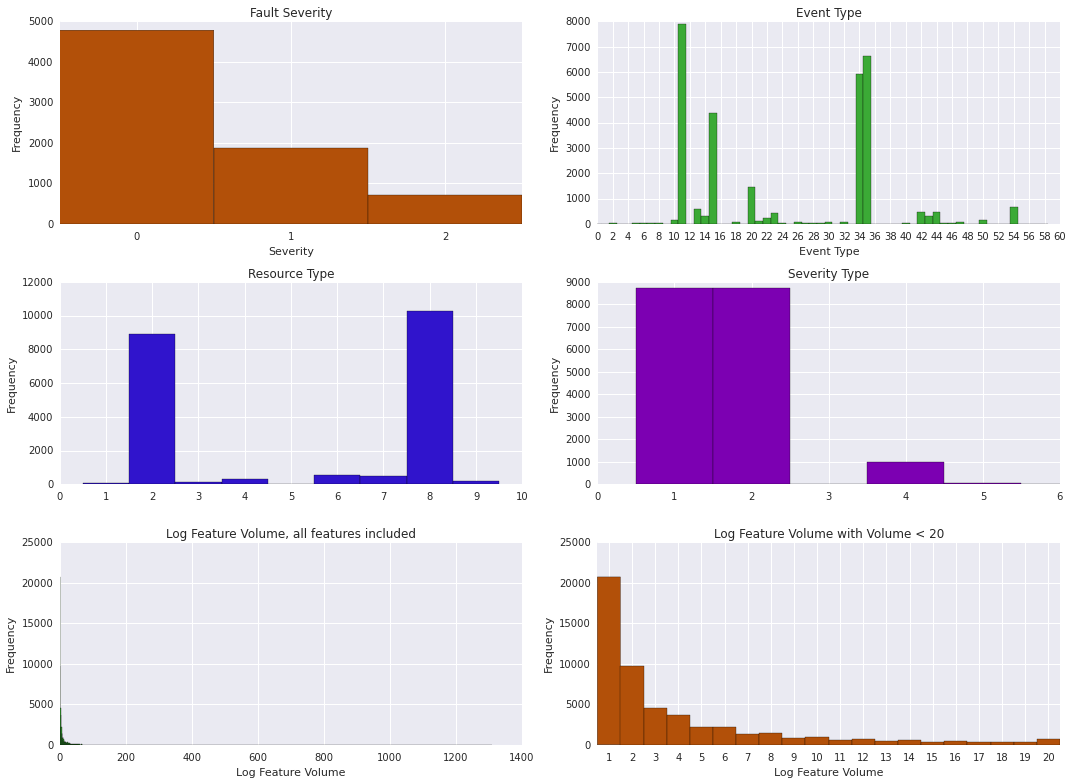

In [3]:
fig = plt.figure(figsize=(15,11))

###Fault Severity
ax1 = fig.add_subplot(321)
ax1.set_title('Fault Severity')
ax1.hist(train.fault_severity, bins=np.arange(4) - 0.5, color='#B25009')
ax1.set_xlabel('Severity')
ax1.set_ylabel('Frequency')
ax1.set_xticks(range(3))

### Event Type
ax2 = fig.add_subplot(322)
ax2.set_title('Event Type')
ax2.hist(events.event_type, bins=np.arange(60)-0.5,color='#3baa36')
ax2.set_xlabel('Event Type')
ax2.set_ylabel('Frequency')
ax2.set_xticks(range(60))
ax2.xaxis.set_major_locator(plt.MaxNLocator(30))


##Resource Type
ax3 = fig.add_subplot(323)
ax3.set_title('Resource Type')
ax3.set_ylabel('Frequency')
ax3.hist(resources.resource_type, bins=np.arange(11)-0.5, color = '#3014CC')
ax3.xaxis.set_major_locator(plt.MaxNLocator(10))

#Severity Type
ax4 = fig.add_subplot(324)
ax4.set_title('Severity Type')
ax4.set_ylabel('Frequency')
ax4.hist(severity.severity_type, bins=np.arange(10)-0.5, color = '#7C00B2')

#Log Feature (All Datapoints)
ax5 = fig.add_subplot(325)
ax5.set_title('Log Feature Volume, all features included')
ax5.set_xlabel('Log Feature Volume')
ax5.set_ylabel('Frequency')
ax5.hist(log_feature.volume,bins=np.arange(log_feature.volume.min(), log_feature.volume.max()+1), align='left',color='#3baa36')

#Log Feature (All Datapoints)
ax6 = fig.add_subplot(326)
ax6.set_title('Log Feature Volume with Volume < 20')
ax6.set_xlabel('Log Feature Volume')
ax6.set_ylabel('Frequency')
ax6.set_xticks(range(21))
ax6.hist(log_feature.volume, bins=np.arange(log_feature.volume.min(), 22), align='left',color='#B25009')

#Display the figure
plt.tight_layout()
sns.plt.show()




Our trainset shows the reports of 7381 incidents in total. Here is what i found out after graphing some of the data.


- As we can see, most of the interruptions are just a temporary network glitch ( *Fault Severity* = 0), but 1 and 2 do seem to cause problems quite frequently (around 35% of the time).

- The *event types* 11,35 and 34, 15 and 2 seem occur a lot together with a network incident ... we should definetly check how this relates in a later chapter.


- The *resource types* 8 and 2 are used most. There is a significant gap between these two resources and the rest.

- The *severity type of warning messages* 1 and 2 seem to be the most frequent ones.

- The *log features* behave a little different here: We have a bunch of different features, which occur in a different Frequency (Volume). The two graphs above show just how often a given feature appears with an issue.
 Since the feature with the largest volume occurs 1350 times, the graph on the bottom left corner is highly skewed.


### Building a DataFrame

Lets have a look on how these features correlate with each other. In order to do so, the data has to be merged together in one single dataframe. Since 'log features' contains a wide variety of features, we will exclude some of the data (features which do not affect a lot of issues) for now and have another look at it later.


fault severity - all - 1
event type - all - 60
resource type - all - 10
severity type - all -1
log features - top 50 by occurence
===
total 122 features

In [33]:
train = pd.read_csv("Telstra/train.csv")
events = pd.read_csv("Telstra/event_type.csv")
log_feature = pd.read_csv("Telstra/log_feature.csv")
resources = pd.read_csv("Telstra/resource_type.csv")
test = pd.read_csv("Telstra/test.csv")
severity = pd.read_csv("Telstra/severity_type.csv")

####### Saving labels
y = train.copy()
y = y.drop('location', axis=1)
y = y.drop('id', axis = 1)

###trainset with id & location
train = train.drop('fault_severity', axis = 1)

### Add Severity type
train = pd.merge(train, pd.DataFrame(severity, columns = ['id', 'severity_type']), on='id',how='left')

### Add Resources
resources = pd.get_dummies(resources, columns=['resource_type'])
resources = resources.groupby(['id']).sum()
resources = resources.reset_index()
train = pd.merge(train, resources, on='id',how='left')


### Add Event Type
events = pd.get_dummies(events, columns=['event_type'])
events = events.groupby(['id']).sum()
events = events.reset_index()
train = pd.merge(train, events, on='id',how='left')


### Edit log_features (by occurence) - drop features not in the top 50
log_feature_by_occurence = log_feature.copy()
log_feature_by_occurence['count'] = log_feature_by_occurence.groupby('log_feature')['log_feature'].transform(pd.Series.value_counts)
log_feature_top50_occ = log_feature_by_occurence.drop('id', axis=1)
log_feature_top50_occ = log_feature_top50_occ.drop('volume', axis=1)
log_feature_top50_occ = log_feature_top50_occ.groupby(['log_feature']).mean()
log_feature_top50_occ = log_feature_top50_occ.sort_values('count', ascending=False).head(50)
log_feature_top50_occ = log_feature_top50_occ.reset_index()

log_feature_by_occurence = log_feature_by_occurence[log_feature_by_occurence['log_feature'].isin(log_feature_top50_occ['log_feature'])]
log_feature_by_occurence = pd.get_dummies(log_feature_by_occurence, columns=['log_feature'])
log_feature_by_occurence = log_feature_by_occurence.groupby(['id']).sum()
log_feature_by_occurence = log_feature_by_occurence.reset_index()
log_feature_by_occurence = log_feature_by_occurence.drop('count', axis=1)


## Edit log_features (by totalvolume) - drop features not in the top 50
log_feature_by_volume = log_feature.copy()
log_feature_top50_vol = log_feature_by_volume.drop('id', axis=1)
log_feature_top50_vol = log_feature_top50_vol.groupby(['log_feature']).sum()
log_feature_top50_vol = log_feature_top50_vol.sort_values('volume', ascending=False).head(50)
log_feature_top50_vol = log_feature_top50_vol.reset_index()

log_feature_by_volume = log_feature_by_volume[log_feature_by_volume['log_feature'].isin(log_feature_top50_vol['log_feature'])]
log_feature_by_volume = pd.get_dummies(log_feature_by_volume, columns=['log_feature'])
log_feature_by_volume = log_feature_by_volume.groupby(['id']).sum()
log_feature_by_volume = log_feature_by_volume.reset_index()


## Appending the log_features to the trainset

train = pd.merge(train, log_feature_by_occurence, on='id',how='left')



Now that we have created our dataframe with our features, lets run the xgboost algorithm on it & see whats happening.

In [34]:
from xgboost import XGBClassifier
from sklearn.cross_validation import train_test_split


test_size = 0.33
X_train, X_test, y_train, y_test = train_test_split(train, y, test_size=test_size, random_state=7)
model = xgboost.XGBClassifier(eval_metric='mlogloss',max_depth=5, n_estimators=120)
model.fit(X_train, y_train)

print(model)

/Library/Python/2.7/site-packages/sklearn/preprocessing/label.py:108: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, eval_metric='mlogloss', gamma=0,
       learning_rate=0.1, max_delta_step=0, max_depth=5,
       min_child_weight=1, missing=None, n_estimators=120, n_jobs=1,
       nthread=1, objective='multi:softprob', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=0, silent=True, subsample=1)


In [35]:
### Add Severity type
test = pd.merge(test, pd.DataFrame(severity, columns = ['id', 'severity_type']), on='id',how='left')

### Add Resources
test = pd.merge(test, resources, on='id',how='left')

### Add Event Type
test = pd.merge(test, events, on='id',how='left')

## Appending the log_features to the trainset

test = pd.merge(test, log_feature_by_occurence, on='id',how='left')




In [36]:

## Show score
from sklearn.metrics import log_loss
from __future__ import division


y_pred = model.predict_proba(X_test)


def accuracy_score(y_true, y_pred):
    return log_loss(y_true, y_pred)

print("Accuracy: %.2f%%" % (accuracy_score(y_test,y_pred)  * 100.0))


Accuracy: 59.02%


In [32]:
##Creating the final prediction data
test_pred = model.predict_proba(test)
final_pred = pd.DataFrame(test['id'])


result_frame = pd.DataFrame(data = test_pred)
final_pred = pd.merge(final_pred, result_frame, left_index=True, right_index=True)
final_pred.columns=['id', 'predict_0','predict_1','predict_2']
#final_pred.to_csv(path_or_buf='Telstra/final_pred.csv',index=False)



